In [1]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import h5py, cv2
from IPython.display import clear_output
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import TimeSeries, print_wise
from project_specific_utils.dataloader import load_eyetracking_data
from image_processing.utils import read_video
from image_processing.gaze_dep_models import wrapper_run_sequential_gaze_dep_mod

In [2]:
from dataclasses import dataclass, field

@dataclass
class Cfg:
    sub_num = 3
    fs = 50
    model_name = "pixelwise_lum";
    sq_side = 250
    downsampling_sq_size = 50
cfg = Cfg()

In [ ]:
from image_processing.utils import get_video_dimensions
cap = cv2.VideoCapture(f"{paths['data_dir']}/stimuli/Project1917_movie_part3_24Hz.mp4")
h, w, frame_n = get_video_dimensions(cap)   

In [10]:
fps = cap.get(cv2.CAP_PROP_FPS)


In [4]:
from image_processing.gaze_dep_models import pixelwise_luminance, save_pixelwise_luminance
rank = 0; 


In [5]:
try:
    wrapper_run_sequential_gaze_dep_mod(paths, rank, cfg.sub_num, pixelwise_luminance, save_pixelwise_luminance, cfg.sq_side, cfg.model_name, cfg.fs, *(cfg.downsampling_sq_size,), screen_res=(1080, 1920), secs_to_skip=5, )
except KeyboardInterrupt:
    pass

12:19:21 - rank 0 Start running pixelwise_lum for sub 3
12:19:21 - rank 0 model already exists at /Users/tizianocausin/1917_local/models/sub003_run01_pixelwise_lum_gazedep_250x250rect_to_50x50_24Hz.h5
12:19:21 - rank 0 model already exists at /Users/tizianocausin/1917_local/models/sub003_run02_pixelwise_lum_gazedep_250x250rect_to_50x50_24Hz.h5
18957
12:19:21 - rank 0 processed first 0th frames
12:19:24 - rank 0 processed first 1000th frames
12:19:27 - rank 0 processed first 2000th frames
12:19:30 - rank 0 processed first 3000th frames
12:19:33 - rank 0 processed first 4000th frames
12:19:36 - rank 0 processed first 5000th frames
12:19:39 - rank 0 processed first 6000th frames
12:19:41 - rank 0 processed first 7000th frames
12:19:44 - rank 0 processed first 8000th frames
12:19:47 - rank 0 processed first 9000th frames
12:19:50 - rank 0 processed first 10000th frames
12:19:53 - rank 0 processed first 11000th frames
12:19:56 - rank 0 processed first 12000th frames
12:19:59 - rank 0 proces

In [9]:
with h5py.File("/Users/tizianocausin/1917_local/models/sub003_run01_pixelwise_lum_gazedep_250x250rect_to_50x50_24Hz.h5", "r") as f:
    feats = f['vecrep'][:]


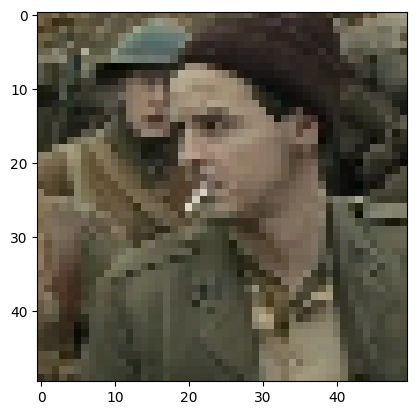

In [10]:
import time
try:
    for i in range(feats.shape[1]):
        f = np.reshape(feats[:, i], (cfg.downsampling_sq_size, cfg.downsampling_sq_size, 3), order='F')
        plt.imshow(f)
        clear_output(wait=True)
        plt.show()
        time.sleep(0.01)
except KeyboardInterrupt:
    pass

In [4]:
from project_specific_utils.dataloader import load_eyetracking_data
g, ts = load_eyetracking_data(paths, cfg.sub_num, 1, cfg.fs)


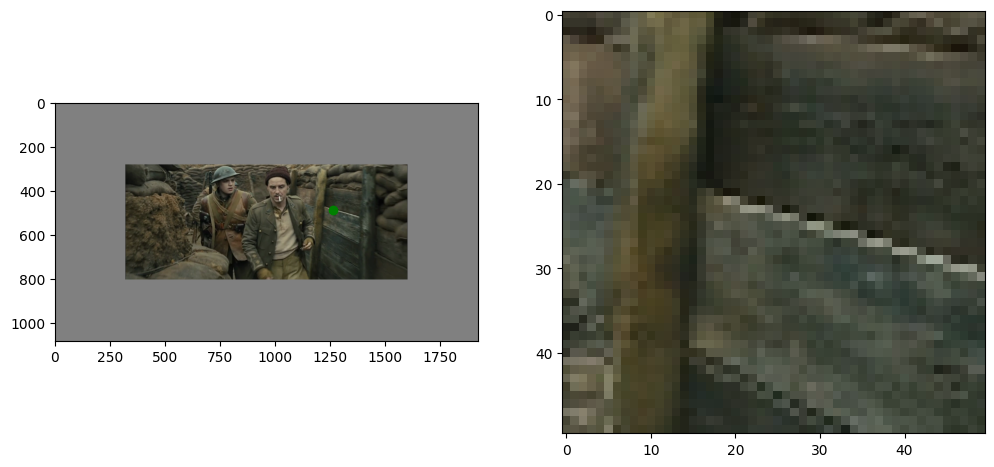

In [11]:
from image_processing.gaze_dep_models import pad_frame, extract_square_patch
from image_processing.utils import get_video_dimensions
plt.ion()
screen_res = (1080, 1920)
gray_value = 128  # mid-gray
sq_side = 224
sq_side_resized = 50
cap = cv2.VideoCapture(f"{paths['data_dir']}/stimuli/Project1917_movie_part1_24Hz.mp4")
h, w, frame_n = get_video_dimensions(cap)
fps = cap.get(cv2.CAP_PROP_FPS)
g.resample(fps)
offset_dims = ((screen_res[0] -h)//2 , ( screen_res[1] - w)//2)
resHor, resVer = 1920, 1080
canvas = None
cap.set(cv2.CAP_PROP_POS_FRAMES, int(5*23.98))
try:
    for idx, xy in enumerate(g):
    
        fig, ax = plt.subplots(1, 2, figsize=(12, 12))
        if idx == 1000:
            break
        # canvas = pad_frame(v[round(5*23.98) + idx-1, :,:,:], movie_dims, offset_dims, canvas=canvas)
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        canvas = pad_frame(frame, (h,w), offset_dims, canvas=None)
        # p = extract_circular_patch(canvas, xy[0], xy[1], 50, fill_value=128)
        p = extract_square_patch(canvas, round(xy[0]), round(xy[1]), sq_side)#, fill_value=128)
        resized = cv2.resize(p, (sq_side_resized, sq_side_resized), interpolation=cv2.INTER_LINEAR)
        ax[0].imshow(canvas)
        ax[0].scatter(xy[0], xy[1], color='green')
        ax[0].set_xlim(0, resHor)
        ax[0].set_ylim(resVer, 0)
        # ax[1].imshow(canvas2)
        # # ax[1].scatter(xy[0], xy[1], color='green')
        # ax[1].set_xlim(0, resHor)
        # ax[1].set_ylim(resVer, 0)
        # assert np.array_equal(canvas2,canvas)
        ax[1].imshow(resized)
        plt.show()
        clear_output(wait=True)
except KeyboardInterrupt:
    pass

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def extract_circular_patch(canvas, cx, cy, radius, fill_value=128):
    """
    Extract a circular patch around (cx, cy) with radius.
    Pads with fill_value if circle goes outside canvas.
    
    canvas: (H, W, C) image
    cx, cy: center coordinates (pixels)
    radius: radius of circle (pixels)
    fill_value: value to fill outside canvas
    """
    H, W, C = canvas.shape
    diameter = 2 * radius
    
    # Initialize patch with fill_value
    patch = np.ones((diameter, diameter, C), dtype=canvas.dtype) * fill_value
    
    # Compute coordinates in canvas
    x_start_canvas = max(cx - radius, 0)
    x_end_canvas   = min(cx + radius, W)
    y_start_canvas = max(cy - radius, 0)
    y_end_canvas   = min(cy + radius, H)
    
    # Compute coordinates in patch
    x_start_patch = max(0, radius - cx)
    x_end_patch   = x_start_patch + (x_end_canvas - x_start_canvas)
    y_start_patch = max(0, radius - cy)
    y_end_patch   = y_start_patch + (y_end_canvas - y_start_canvas)
    
    # Copy pixels into patch
    patch[y_start_patch:y_end_patch, x_start_patch:x_end_patch, :] = \
        canvas[y_start_canvas:y_end_canvas, x_start_canvas:x_end_canvas, :]
    
    # Create circular mask
    Y, X = np.ogrid[:diameter, :diameter]
    dist_from_center = np.sqrt((X - radius)**2 + (Y - radius)**2)
    circle_mask = dist_from_center <= radius
    
    # Apply mask: everything outside circle -> fill_value
    patch[~circle_mask] = fill_value
    circle_pixels = patch[circle_mask]
    return circle_pixels#patch
